rappel information SAM `Predictor.forward` sur multimask_output :
>  multimask_output (bool): If true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, multimask_output=False can give better results.

In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, resize
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import IMG_SIZE
from src.data.process import generate_grid_prompt
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr

In [4]:
from src.commons.utils_io import load_sam
from src.models.commons.bisam import BiSam2, SamModeInference
from src.models.segment_any_change.model import BiSam

from src.commons.utils import batch_to_list

In [5]:
def show_prompts_on_mask(mask: torch.Tensor, batch, batch_idx: int):
    if mask.shape[-1] != IMG_SIZE[0]:
        mask = resize(mask, IMG_SIZE)
    coord_points = batch["point_coords"][batch_idx]
    mask_pt = get_mask_with_prompt(binarize_mask(mask[batch_idx], th=0) , coord_points)
    show_img(mask_pt)

In [6]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [7]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        )

In [8]:
batch = next(iter(dloader))

In [11]:
bisam2 = load_sam(
    model_type="vit_b", model_cls=BiSam2, version= "rawb", device="cpu"
)

2024-08-13 10:48:43,900 - INFO ::  build vit_b BiSam2


In [12]:
bisam = load_sam(
    model_type="vit_b", model_cls=BiSam, version= "dev", device="cpu"
)

2024-08-13 10:48:45,034 - INFO ::  build vit_b BiSam


INIT VIT


In [13]:
out = bisam2(batch, multimask_output=True)

patch embed : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


### multioutput == True

In [14]:
preds = (out["masks"] > 0.).squeeze(2)

In [15]:
preds.shape

torch.Size([2, 1, 3, 256, 256])

In [16]:
idx_max = torch.argmax(out["iou_predictions"], dim=2)
expanded_indices = idx_max.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 1, 256, 256)
# Use gather to select elements along dim 2
selected_elements = torch.gather(preds, 2, expanded_indices).squeeze(2)

In [17]:
selected_elements.shape

torch.Size([2, 1, 256, 256])

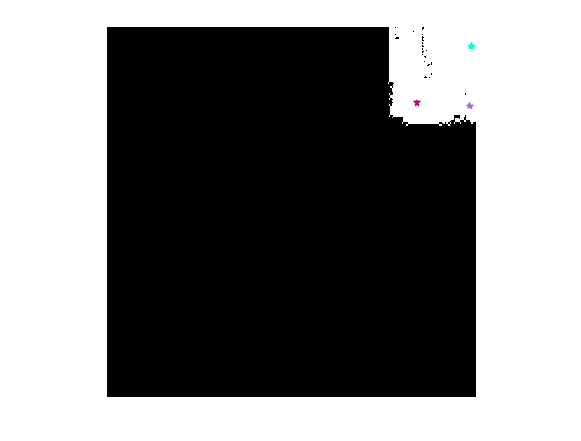

In [18]:
show_prompts_on_mask(selected_elements.squeeze(1), batch, 0)

In [19]:
selected_elements.shape

torch.Size([2, 1, 256, 256])

### multioutput == False

In [20]:
out = bisam2(batch, multimask_output=False)

patch embed : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [21]:
out["masks"].shape

torch.Size([2, 1, 1, 256, 256])

In [22]:
preds = bisam2.upscale_masks(out["masks"], (1024, 1024))

In [23]:
preds.shape

torch.Size([2, 1, 1, 1024, 1024])

In [24]:
preds = (preds > 0.).squeeze(1)
preds.shape

torch.Size([2, 1, 1024, 1024])

TypeError: Invalid shape (1, 1024, 1024) for image data

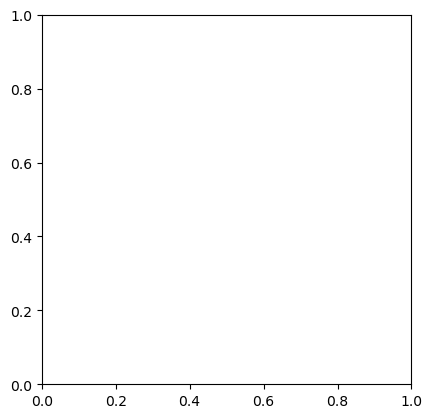

In [25]:
show_prompts_on_mask(preds, batch, 0)

In [ ]:
idx = 0
mask = preds[idx]
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

On prédit un seul masque dans les deux cas car tous les pormpts sont associés à un meme objet !

In [ ]:
plt.imshow(to_numpy(preds[1], transpose=False))

In [ ]:
preds[0].shape

In [4]:
from src.models.segment_anything import sam_model_registry_ori, SamPredictor
from src.commons.constants import SAM_MODEL_SMALL_PATH

idx= 0
img_path = f"/home/MDizier/data/dl/levir-cd/test/B/test_{idx+1}.png"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = "cpu"
model_type = "vit_b"

sam = sam_model_registry_ori[model_type](checkpoint=SAM_MODEL_SMALL_PATH)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)


2024-07-19 17:20:49,911 - INFO ::  build SAM


In [73]:
batch["point_coords"][idx].shape

torch.Size([3, 2])

In [74]:
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  

input_point = to_numpy(point_coords, transpose=False)
input_label = to_numpy(point_labels, transpose=False)

In [75]:
input_label.shape, input_point.shape

((3,), (3, 2))

In [76]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


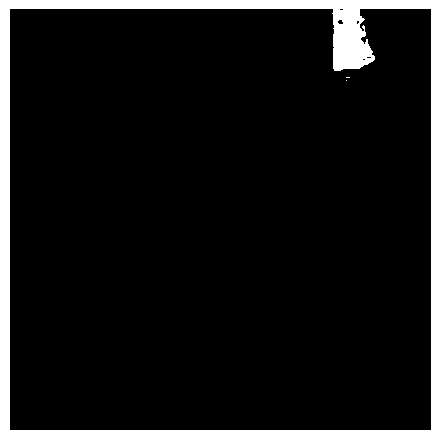

In [77]:
show_img(masks.squeeze())

### batch prompt
* un prompt == un objet

In [78]:
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  
input_point = point_coords.clone().to(device)
input_label = point_labels.clone().to(device)
input_point.shape, input_label.shape

(torch.Size([3, 2]), torch.Size([3]))

In [79]:
masks, ious, _ = predictor.predict_torch(
    point_coords=input_point[:,None ,:],
    point_labels=input_label[:, None],
    boxes=None,
    multimask_output=False,
)

sparse emb : torch.Size([3, 2, 256])
dense emb : torch.Size([3, 256, 64, 64])
low mask  predict torch : torch.Size([3, 1, 256, 256])
low mask  predict torch : torch.Size([3, 1, 1024, 1024])


In [80]:
masks.shape

torch.Size([3, 1, 1024, 1024])

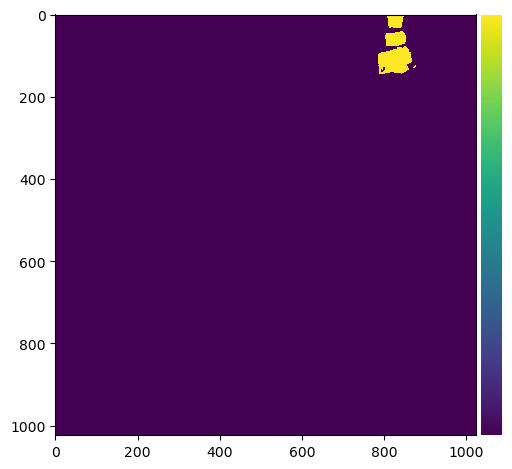

In [81]:
show_img(to_numpy(torch.sum(masks.squeeze(), dim=0), transpose=False))

Ok ! La onna chaque prompt pour un objet different!

In [85]:
batch["point_coords"].shape, input_point.shape

(torch.Size([2, 3, 2]), torch.Size([3, 2]))

In [87]:
idx = 0
masks, ious, _ = predictor.predict_torch(
    point_coords=batch["point_coords"][idx][None, : ,:].to(device),
    point_labels=batch["point_labels"][idx][None, :].to(device),
    boxes=None,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


In [90]:
masks.shape

torch.Size([1, 1, 1024, 1024])

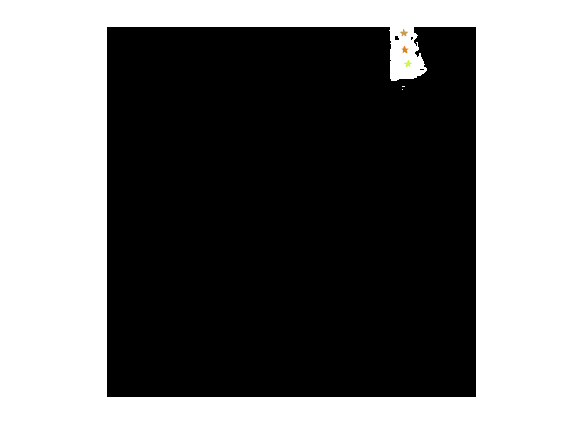

In [93]:
show_prompts_on_mask(masks.squeeze(0), batch, 0)

### change model : many prompt to one mask :

In [27]:
from src.commons.utils_io import load_config
import hydra
from hydra.core.global_hydra import GlobalHydra

In [99]:
GlobalHydra.instance().clear()
list_args=["experiment=probing_diff", "sam_type=small", "data=levir-cd", "data.params.n_shape=3", "data.params.batch_size=4"]
cfg = load_config(list_args)

In [100]:
module = hydra.utils.instantiate(cfg.model.instance)

INIT VIT


2024-08-13 11:39:14,999 - INFO ::  Weights loaded for : ['image_encoder']


In [101]:
data_module = hydra.utils.instantiate(cfg.data)

In [102]:
data_module.params

{'prompt_type': 'sample', 'n_prompt': 1, 'loc': 'center', 'batch_size': 4, 'num_worker': 4, 'pin_memory': False, 'n_shape': 3}

In [103]:
data_module.setup("fit")
train_dloader = data_module.train_dataloader()

In [104]:
batch = next(iter(train_dloader))

### Modif mask decoder

In [196]:
out = bisam2(batch, multimask_output=False)
preds2 = out["masks"] > 0
print(preds2.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 1, 1, 256, 256])


In [93]:
out = bisam(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = out["masks"] > 0
print(preds.shape)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
torch.Size([2, 3, 1, 256, 256])


In [19]:
# bisam diff modified => 1 mask for all prompt
preds_diff2, ious = module.model(batch, multimask_output=False)
preds_diff2 = preds_diff2 > 0
print(preds_diff2.shape)

torch.Size([2, 1, 1, 256, 256])


In [105]:
point_coords = (
    batch["point_coords"].clone()
)
point_labels = (
    batch["point_labels"].clone()
)

In [106]:
point_coords.shape

torch.Size([4, 3, 2])

In [107]:
batch["point_coords"]

tensor([[[1009.,  973.],
         [ 714.,  944.],
         [ 827.,  949.]],

        [[  97.,  113.],
         [ 503.,  513.],
         [ 747.,  914.]],

        [[ 791.,  602.],
         [ 816.,  889.],
         [ 273.,  636.]],

        [[ 601.,  937.],
         [ 295.,   45.],
         [ 390., 1022.]]])

In [108]:
point_coords.shape, point_labels.shape

(torch.Size([4, 3, 2]), torch.Size([4, 3]))

In [109]:
# batch prompt encoding
sparse_embeddings, dense_embeddings = bisam.prompt_encoder(
    points=(
        point_coords[:,:,None ,:],#[0][None, :, :],
        point_labels[..., None] #[0][None, :],
    ),
    boxes=None,
    masks=None,
)

In [110]:
sparse_embeddings.shape

torch.Size([4, 3, 2, 256])

In [111]:
sparse_embeddings[0, 0, 0, :]

tensor([ 0.3530, -0.8905,  0.7160, -0.8182, -0.6237,  0.5368, -0.9532,  0.4164,
        -0.9119,  0.1683, -0.7790, -0.9896,  0.1486,  0.9730,  0.2087,  0.9903,
        -0.2774, -1.1057, -0.8963, -0.4908, -0.8837, -0.5712, -0.9170, -0.7063,
         0.4535, -0.0978, -0.4768, -0.9002,  0.9414,  0.9618, -0.5216, -0.7716,
        -1.0008, -0.3282,  0.2182,  0.4155, -0.6662,  0.6892,  0.7966, -0.9256,
         0.7563,  0.7376, -0.8840, -0.5098,  0.5904,  0.9548, -0.5567, -0.4909,
        -0.9631, -0.9984, -0.6654, -0.7772,  0.9799, -0.3353,  1.1086, -0.9716,
         0.0896,  0.5330,  0.3547, -0.4503, -0.6016,  0.9639, -0.5275,  0.7675,
         0.8267,  0.7380, -0.9070,  0.9803,  0.8558, -0.0360, -0.9952, -0.9489,
         0.7836,  0.5722,  1.0016, -0.6392,  0.9323, -0.1206, -0.7582,  0.9738,
         0.8206,  1.3001,  0.6252, -0.3897, -0.9672,  0.8216, -0.9999,  0.6947,
        -0.4822, -0.6305, -0.4512, -0.7268, -0.8398, -0.2256,  0.9745, -0.7307,
        -0.0593, -0.0845, -0.3047, -0.00

In [112]:
sparse_embeddings_, dense_embeddings_ = bisam2.prompt_encoder(
    points=(
        point_coords, #,[:,None ,:],#[0][None, :, :],
        point_labels,#[:, None] #[0][None, :],
    ),
    boxes=None,
    masks=None,
)

* sparse_embeddings[0, 0, 1,:] == sparse_embeddings_[0, 3, :]
* sparse_embeddings[0, 0, 0,:] == sparse_embeddings_[0, 0, :]

In [113]:
sparse_embeddings_[0, 2, :]

tensor([ 0.7575, -0.3270, -0.4895,  0.8766,  0.9722,  1.1187, -0.5502,  0.6301,
        -0.9937, -0.1834,  0.9411, -0.4831, -0.9247, -0.2155,  0.2782,  0.0096,
         0.4542, -1.0499, -1.0396, -0.9660, -0.8877,  0.5656,  0.8579, -0.8785,
        -0.8894,  1.0067, -1.0211,  0.4184,  0.0828, -0.9666,  0.8618, -0.3334,
        -0.1706,  0.8104, -0.0256,  0.1722,  0.9343, -0.4250,  0.0454,  0.9827,
        -1.0070,  0.8996, -0.4020, -0.7107,  0.1515, -0.5883, -0.4017,  0.7073,
        -0.3421,  0.9416, -0.8861,  0.9587,  0.1983, -0.8158, -0.4675,  0.7317,
         0.5201, -0.7027,  0.8060,  0.9762,  0.7780, -0.2790,  0.0183,  0.8221,
         0.9212, -0.0426,  0.7203, -1.0096,  0.8147,  0.9650,  0.8566, -0.9849,
        -0.9038, -0.1035,  0.5258,  1.2742,  0.2722, -0.5992,  0.7890, -0.6211,
        -0.0973,  0.5773, -0.1056,  0.5318,  0.9332,  0.9701,  0.9664, -1.0048,
        -1.0864, -0.9014, -0.1924,  0.9897,  0.9653,  0.0812, -0.9410,  0.8867,
         0.1430, -0.4952,  0.2961,  0.79

In [114]:
print(f"sparse_embeddings: {sparse_embeddings_.shape}")
print(f"dense_embeddings: {dense_embeddings_.shape}")

sparse_embeddings: torch.Size([4, 4, 256])
dense_embeddings: torch.Size([4, 256, 64, 64])


On veut sparse : 2, 4, 256

In [45]:
image_embeddings = bisam2.image_embeddings

In [46]:
image_embeddings.shape

torch.Size([2, 256, 64, 64])

In [206]:
low_res_masks, iou_predictions =  bisam2.mask_decoder(
    image_embeddings=image_embeddings,  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, N, 256, 64, 64)
    multimask_output=False,
)

In [48]:
low_res_masks, iou_predictions =  bisam2.mask_decoder(
    image_embeddings=image_embeddings[0].unsqueeze(0),  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings[0],  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings[0],  # (B, N, 256, 64, 64)
    multimask_output=False,
)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [47]:
low_res_masks, iou_predictions =  module.model.mask_decoder(
    image_embeddings=image_embeddings[0].unsqueeze(0),  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings[0],  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings[0],  # (B, N, 256, 64, 64)
    multimask_output=False,
)

RuntimeError: Tensors must have same number of dimensions: got 4 and 2

In [216]:
low_res_masks.shape

torch.Size([3, 1, 256, 256])

In [168]:
# masks =  module.model.upscale_masks(low_res_masks.unsqueeze(0), IMG_SIZE)
# # masks, iou_predictions =  module.model.select_masks(
# #     masks, iou_predictions, multimask_output=False
# # )

In [207]:
masks = masks > 0

In [174]:
masks.shape

torch.Size([1, 2, 1, 1024, 1024])

In [223]:
preds2.shape

torch.Size([2, 1, 1, 256, 256])

In [27]:
batch["label_path"]

['/home/MDizier/data/dl/levir-cd/train/label/train_1.png',
 '/home/MDizier/data/dl/levir-cd/train/label/train_2.png']

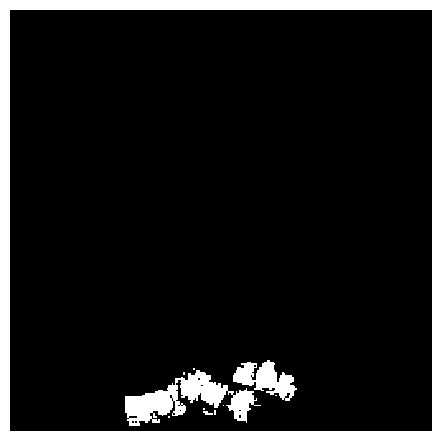

In [224]:
show_img(to_numpy(preds2[0].squeeze(), transpose=False))

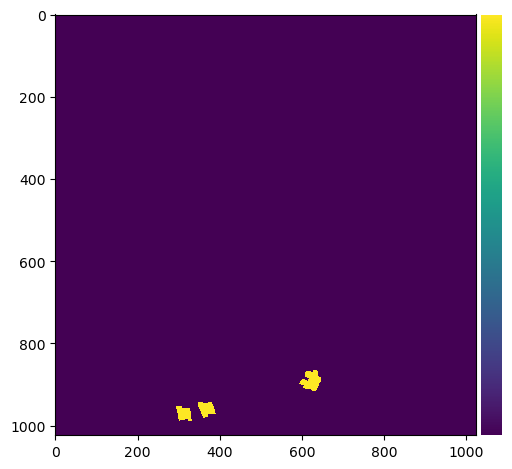

In [208]:
show_img(to_numpy(batch["label"][0], transpose=False))

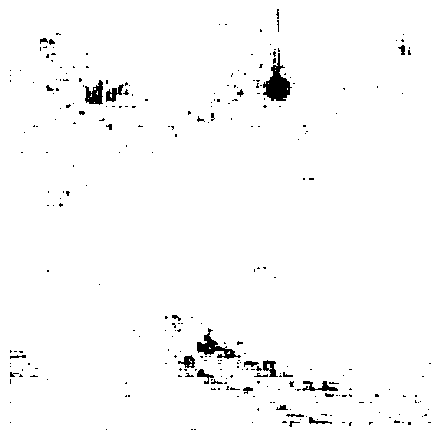

In [218]:
show_img(to_numpy(masks.squeeze()[0], transpose=False))

In [20]:
print(preds_diff2.shape)

torch.Size([2, 1, 1, 256, 256])


In [25]:
preds_diff2.dtype

torch.bool

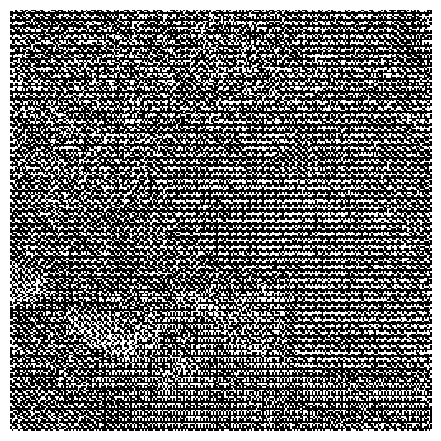

In [24]:
show_img(to_numpy(preds_diff2.squeeze()[0], transpose=False))

In [42]:
print(batch["label_path"])

['/home/MDizier/data/dl/levir-cd/train/label/train_1.png', '/home/MDizier/data/dl/levir-cd/train/label/train_2.png']


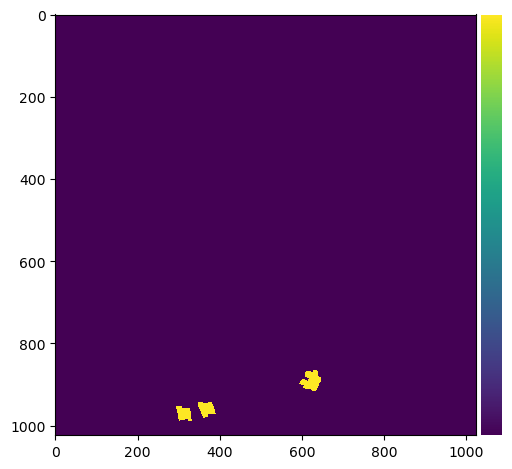

In [43]:
show_img(to_numpy(batch["label"][0], transpose=False))

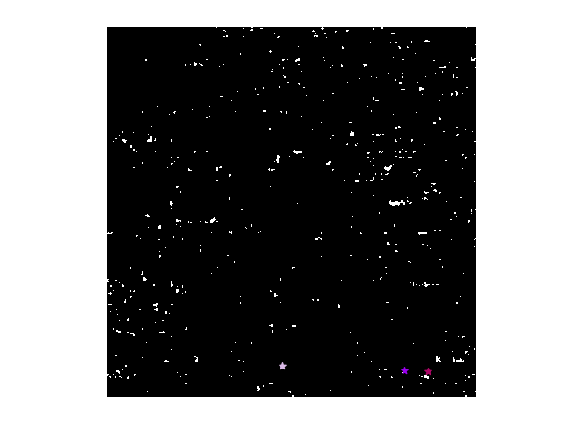

In [28]:
show_prompts_on_mask(masks[1].squeeze(0), batch, 0)

In [67]:
out = bisam2(batch, multimask_output=False)
preds2 = out["masks"] > 0
print(preds2.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 1, 1, 256, 256])


In [93]:
out = bisam(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = out["masks"] > 0
print(preds.shape)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
torch.Size([2, 3, 1, 256, 256])


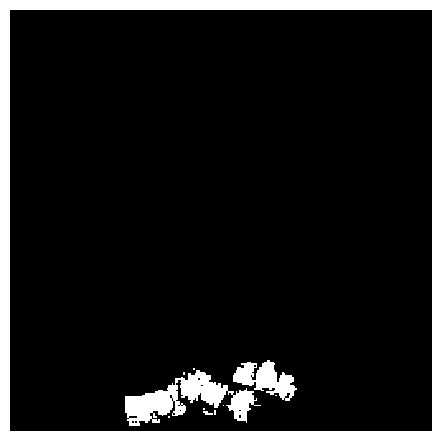

In [73]:
show_img(to_numpy(torch.sum(preds2.squeeze(2), dim=1)[0], transpose=False))

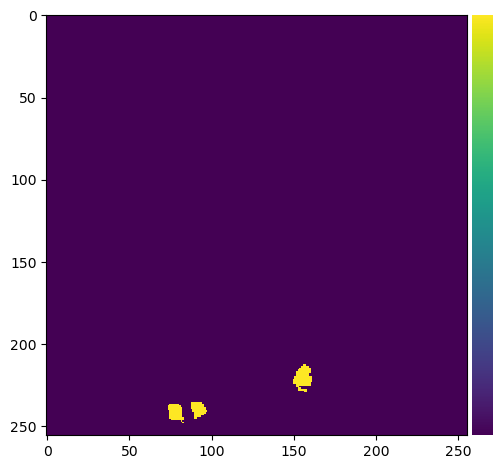

In [94]:
show_img(to_numpy(torch.sum(preds.squeeze(), dim=1)[0], transpose=False))

On a bine deux inférence différentes : 
* la premiere considère les points et extraits un seul mask.
* la deuxieme considère un mask par point

### Check predictor : ok

In [86]:
image = to_numpy(batch["img_B"][0]).astype(np.uint8)

In [87]:
image.dtype

dtype('uint8')

In [88]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [73]:
batch["point_coords"][idx].shape

torch.Size([3, 2])

In [89]:
idx=0
point_coords = batch["point_coords"][idx]
# remove padding points
point_coords = point_coords[torch.sum(point_coords, dim=1) > 0]
# remove padding points
point_labels = batch["point_labels"][idx]
point_labels = point_labels[:point_coords.shape[0]]  

input_point = to_numpy(point_coords, transpose=False)
input_label = to_numpy(point_labels, transpose=False)

In [90]:
input_label.shape, input_point.shape

((3,), (3, 2))

In [91]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


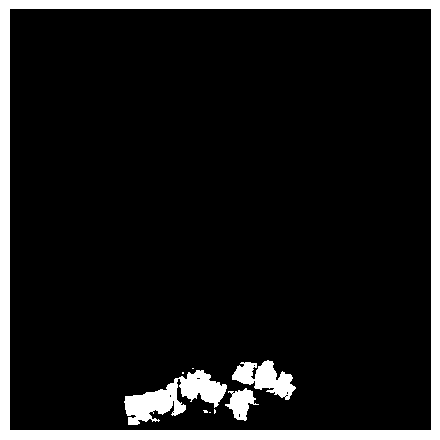

In [92]:
show_img(masks.squeeze())

TypeError: Invalid shape (3, 1024, 1024) for image data

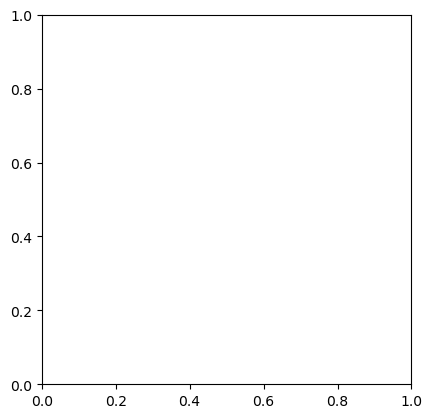

In [55]:
show_prompts_on_mask(preds.squeeze(), batch, 0)

In [28]:
module.model.prompt_encoder.get_dense_pe().shape

torch.Size([1, 256, 64, 64])

### Annexes

In [115]:
image_embeddings.shape

torch.Size([2, 256, 64, 64])

In [116]:
from torch import nn

In [117]:
max_pool = nn.MaxPool2d(kernel_size=(16, 16), stride=(16, 16))

In [124]:
out = max_pool(image_embeddings)

In [125]:
out.shape

torch.Size([2, 256, 4, 4])

In [126]:
out.view(*out.shape[:2], -1).shape

torch.Size([2, 256, 16])